
# Analyse des attaquants

Ce notebook constitue la **version finale** de l'analyse des attaquants (FW) basée sur les données agrégées des cinq grands championnats européens (source : FBref).  
Il se concentre sur quatre axes, avec pour chacun :
- **Pourquoi on le fait** (objectif analytique),
- **Méthode utilisée** (technique statistique/graphique),
- **Pourquoi c’est pertinent** (enjeux football & data),
- **Visualisations** (simples, interprétables).




In [2]:

# Imports et chargement des données
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CSV_PATH = "assembled_data_FW_normalized.csv"
df = pd.read_csv(CSV_PATH)
print("Lignes:", len(df), "| Colonnes:", len(df.columns))
df.head(5)


Lignes: 545 | Colonnes: 148


,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MainPos,MP,...,Subs_per_90,PPM_per_90,onG_per_90,onGA_per_90,+/-_per_90,+/-90_per_90,onxG_per_90,onxGA_per_90,xG+/-_per_90,xG+/-90_per_90
0,2415,Aaron Seydel,de GER,FW,Darmstadt 98,de Bundesliga,27.0,1996.0,FW,16,...,1.599354,0.072698,0.872375,2.180937,-1.308562,-0.190468,0.828756,1.962843,-1.134087,-0.165751
1,835,Abde Ezzalzouli,ma MAR,FW,Betis,es La Liga,21.0,2001.0,FW,28,...,1.929260,0.161576,1.061093,0.868167,0.192926,0.137942,1.099678,1.225080,-0.125402,-0.012540
2,2202,Abde Rebbach,dz ALG,"FW,MF",Alavés,es La Liga,24.0,1998.0,FW,23,...,2.119114,0.087258,0.623269,0.747922,-0.124654,-0.014958,0.934903,0.847645,0.087258,0.011219
3,1274,Abdoul Kader Bamba,fr FRA,"FW,MF",Nantes,fr Ligue 1,29.0,1994.0,FW,23,...,3.240589,0.103110,1.178396,2.504092,-1.325696,-0.195908,1.472995,2.356792,-0.898527,-0.131097
4,755,Abdoulaye Doucouré,ml MLI,"FW,MF",Everton,eng Premier League,30.0,1993.0,FW,32,...,0.000000,0.049296,1.129707,1.232408,-0.102701,-0.003423,1.379612,1.430962,-0.051350,-0.001712



## 1) Inspection des colonnes & mappage sémantique

**Pourquoi ?** Comprendre la structure des données et identifier les colonnes clés (buts, xG, tirs, assists...).  
**Méthode :** inspection des noms de colonnes puis détection « robuste » par recherche de motifs dans les noms (sans alias SQL).  
**Pertinence :** un bon mappage garantit des analyses cohérentes et reproductibles malgré les variations de nommage.


In [3]:

# Utilitaires de détection de colonnes (robuste, sans alias SQL)
import re

def smart_find_column(df_columns, candidates=None, contains=None, regex=None):
    cols = list(df_columns)
    lcols = [c.lower() for c in cols]
    if candidates:
        cand_lower = [c.lower() for c in candidates]
        for i, lc in enumerate(lcols):
            if lc in cand_lower:
                return cols[i]
    if contains:
        contains_lower = [s.lower() for s in contains]
        for i, lc in enumerate(lcols):
            if any(s in lc for s in contains_lower):
                return cols[i]
    if regex:
        for i, lc in enumerate(lcols):
            if re.search(regex, lc):
                return cols[i]
    return None

def ensure_ratio_column(df, num_col, den_col, new_name):
    if num_col in df.columns and den_col in df.columns:
        with np.errstate(divide="ignore", invalid="ignore"):
            df[new_name] = np.where(df[den_col] > 0, df[num_col] / df[den_col], np.nan)
        return new_name
    return None


In [4]:

# Mappage des colonnes clés (si présentes dans le CSV)
col_goals = smart_find_column(df.columns, candidates=["Goals","Gls"], contains=["goals","gls"])
col_xg = smart_find_column(df.columns, candidates=["xG"], contains=["xg","expected"])
col_shots_total = smart_find_column(df.columns, candidates=["Shots_Total","Sh"], contains=["shots_total","shots","sh"])
col_shots_on_target = smart_find_column(df.columns, candidates=["Shots_on_Target","SoT"], contains=["shots_on_target","sot","on_target"])
col_assists = smart_find_column(df.columns, candidates=["Assists","Ast"], contains=["assists","ast"])
col_xa = smart_find_column(df.columns, candidates=["xA"], contains=["xa","expected_assists"])
col_sca = smart_find_column(df.columns, candidates=["Shot_Creating_Actions","SCA"], contains=["shot_creating_actions","sca"])
col_gca = smart_find_column(df.columns, candidates=["Goal_Creating_Actions","GCA"], contains=["goal_creating_actions","gca"])
col_touches_in_box = smart_find_column(df.columns, contains=["touches_in_box","att_pen","penalty area","touches_att_pen"])
col_prgr = smart_find_column(df.columns, candidates=["Progressive_Passes_Received","PrgR"], contains=["progressive_passes_received","prgr"])
col_prgc = smart_find_column(df.columns, candidates=["Progressive_Carries","PrgC"], contains=["progressive_carries","prgc"])
col_pressures = smart_find_column(df.columns, candidates=["Pressures"], contains=["pressures"])
col_succ_pressures = smart_find_column(df.columns, contains=["successful_pressures","succ_press"])
col_tackles = smart_find_column(df.columns, candidates=["Tackles","Tkl"], contains=["tackles","tkl"])

gps_name = ensure_ratio_column(df, col_goals, col_shots_total, "Goals_per_Shot")
xgps_name = ensure_ratio_column(df, col_xg, col_shots_total, "xG_per_Shot")

core_cols = [c for c in [
    col_goals, col_xg, col_shots_total, col_shots_on_target, col_assists, col_xa,
    col_sca, col_gca, col_touches_in_box, col_prgr, col_prgc,
    col_pressures, col_succ_pressures, col_tackles, gps_name, xgps_name
] if c]

core_cols


['Gls',
 'xG',
 'Sh_shooting',
 'SoT',
 'Ast',
 'xA',
 'PrgR',
 'PrgC',
 'Tkld',
 'Goals_per_Shot',
 'xG_per_Shot']


## 2) Statistiques descriptives (repères d’échelle)

**Pourquoi ?** Situer les grandeurs (médianes, dispersion) pour éviter des conclusions biaisées.  
**Méthode :** `describe()` sur les variables clés.  
**Pertinence :** détecte effectifs atypiques (très faibles minutes), distributions très asymétriques, et prépare les corrélations.


In [5]:

desc = df[core_cols].describe().T
desc


,count,mean,std,min,25%,50%,75%,max
Gls,545.0,5.040367,5.193872,0.0,1.000000,4.000000,7.000000,36.00
xG,545.0,4.792844,4.633280,0.0,1.400000,3.500000,6.400000,30.60
Sh_shooting,545.0,34.935780,26.625837,0.0,13.000000,31.000000,51.000000,141.00
SoT,545.0,13.313761,11.154772,0.0,4.000000,11.000000,20.000000,61.00
Ast,545.0,2.245872,2.492287,0.0,0.000000,1.000000,3.000000,13.00
xA,545.0,1.842936,1.863541,0.0,0.500000,1.200000,2.700000,11.00
PrgR,545.0,102.779817,77.360686,1.0,39.000000,88.000000,149.000000,508.00
PrgC,545.0,36.205505,36.213343,0.0,10.000000,23.000000,51.000000,184.00
Tkld,545.0,21.001835,18.631340,0.0,7.000000,16.000000,31.000000,101.00
Goals_per_Shot,534.0,0.154074,0.256661,0.0,0.071429,0.120000,0.181818,3.00



## 3) Efficacité de tir vs Volume de tirs

**Pourquoi on le fait ?**  
Évaluer si **tirer plus** (volume) est synonyme de **marquer plus** (output) et vérifier la **cohérence** avec la qualité des occasions (*xG*).

**Méthode utilisée :**  
- **Matrice de corrélations (Pearson)** sur `Tirs`, `Tirs cadrés`, `Buts`, `xG`, `Buts/Tir`, `xG/Tir`.  
- **Scatter plots** pour observer la relation linéaire et les outliers (*sur/sous-performers*).  
Les corrélations sont calculées uniquement sur valeurs numériques (NaN ignorés).

**Pourquoi c’est pertinent ?**  
- Valide l’alignement entre **production** (buts) et **qualité des occasions** (xG).  
- Repère les profils **hyper-efficaces** (conversion au-dessus des attentes) vs **gros volume peu efficace**.


In [6]:

def corr_heatmap(df, columns, title):
    sel = [c for c in columns if c in df.columns]
    if len(sel) < 2:
        print(f"[Info] Pas assez de colonnes pour {title}. Colonnes trouvées:", sel)
        return None
    corr = df[sel].corr(numeric_only=True)
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(corr.values, aspect='auto')
    ax.set_xticks(range(len(sel)))
    ax.set_yticks(range(len(sel)))
    ax.set_xticklabels(sel, rotation=45, ha='right')
    ax.set_yticklabels(sel)
    plt.title(title)
    plt.colorbar(im)
    # annotations
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            ax.text(j, i, f"{corr.values[i, j]:.2f}", ha="center", va="center")
    plt.tight_layout()
    plt.show()
    return corr

def scatter_plot(df, x, y, title):
    if x in df.columns and y in df.columns:
        plt.figure(figsize=(6,5))
        plt.scatter(df[x], df[y])
        plt.xlabel(x); plt.ylabel(y)
        plt.title(title)
        plt.tight_layout()
        plt.show()


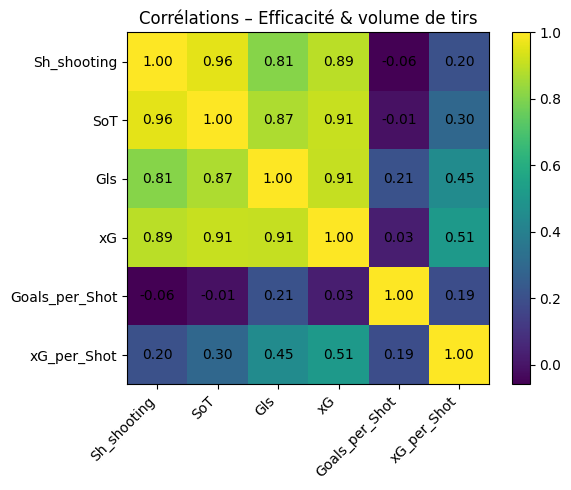

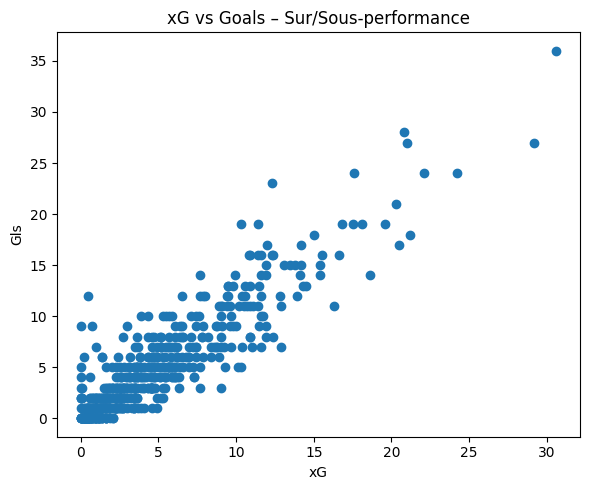

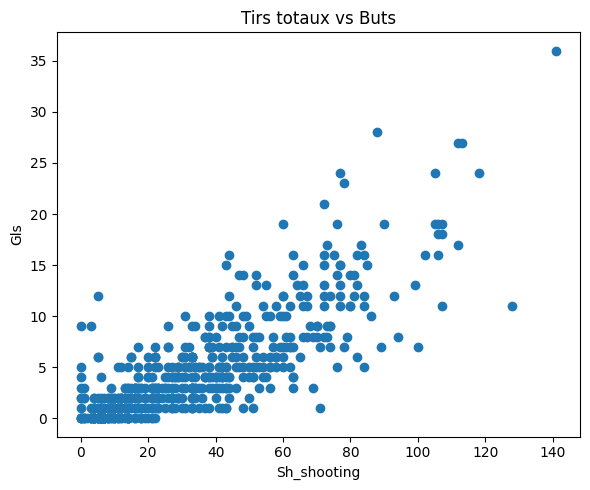

In [7]:

shooting_cols = [c for c in [col_shots_total, col_shots_on_target, col_goals, col_xg, gps_name, xgps_name] if c]
corr1 = corr_heatmap(df, shooting_cols, "Corrélations – Efficacité & volume de tirs")
if col_xg and col_goals:
    scatter_plot(df, col_xg, col_goals, "xG vs Goals – Sur/Sous-performance")
if col_shots_total and col_goals:
    scatter_plot(df, col_shots_total, col_goals, "Tirs totaux vs Buts")



**Lecture & limites :**  
- Corrélation forte *Goals–xG* → finition « attendue ». Écart persistant → sur/sous-performance.  
- Les ratios `Buts/Tir` et `xG/Tir` sont sensibles à de **faibles volumes** (effet bruit).  
- Normaliser par **90 minutes** si les minutes varient fortement pour éviter les biais d’exposition.



## 4) Création (passes/chaînes d’attaque) vs Finition

**Pourquoi on le fait ?**  
Mesurer si les attaquants **créateurs** (SCA, GCA, xA) sont aussi **finisseurs** (Goals, xG), pour décrire des **profils**.

**Méthode utilisée :**  
- **Corrélation Pearson** sur `Goals, xG, Assists, xA, SCA, GCA`.  
- **Scatter** SCA → Goals pour visualiser les profils « impliqués partout » vs « finisseurs purs ».

**Pourquoi c’est pertinent ?**  
- Identifie les attaquants complets (créent & terminent) vs spécialistes.  
- Aide au **recrutement** / **tactique** : associer des profils complémentaires.


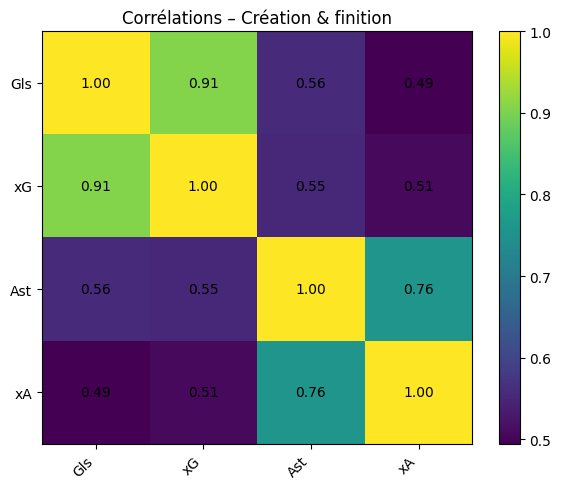

In [8]:

creation_cols = [c for c in [col_goals, col_xg, col_assists, col_xa, col_sca, col_gca] if c]
corr2 = corr_heatmap(df, creation_cols, "Corrélations – Création & finition")
if col_sca and col_goals:
    scatter_plot(df, col_sca, col_goals, "Actions menant à un tir (SCA) vs Buts")



**Lecture & limites :**  
- *Assists–xA* élevé → passes réellement converties (teammates importants).  
- *SCA/GCA* → dépend du **style d’équipe** (possession/transition).  
- La **position exacte** (wing vs 9) influence naturellement les corrélations.



## 5) Implication dans le jeu (progressions, touches) vs Production

**Pourquoi on le fait ?**  
Comprendre si la **présence dans la zone dangereuse** et la **participation aux progressions** sont liées aux buts/assists.

**Méthode utilisée :**  
- **Corrélations** entre `Touches_in_Box`, `PrgR`, `PrgC` et `Goals`, `xG`, `Assists`.  
- **Scatter** `Touches_in_Box` → `Goals` pour illustrer la relation zone de vérité ↔ finition.

**Pourquoi c’est pertinent ?**  
- Différencie profil **renard des surfaces** (beaucoup de touches dans la surface) vs **associatif** (progressions, appuis).  
- Aligne le **profil d’attaquant** avec le **plan de jeu**.


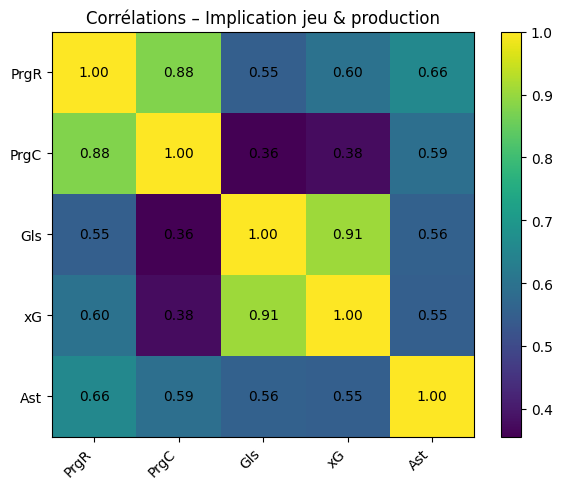

In [9]:

involv_cols = [c for c in [col_touches_in_box, col_prgr, col_prgc, col_goals, col_xg, col_assists] if c]
corr3 = corr_heatmap(df, involv_cols, "Corrélations – Implication jeu & production")
if col_touches_in_box and col_goals:
    scatter_plot(df, col_touches_in_box, col_goals, "Touches dans la surface vs Buts")



**Lecture & limites :**  
- Une corrélation *Touches_in_Box–Goals* soutient l’idée « la zone de tir compte ».  
- *PrgR/PrgC* élevés peuvent aussi refléter des **ailiers forts en un-contre-un** plus que des 9.



## 6) Contribution défensive (pressing) vs Performance offensive

**Pourquoi on le fait ?**  
Dans les projets modernes, l’attaquant initie le **pressing** : on teste si cette charge coexiste avec la production.

**Méthode utilisée :**  
- **Corrélations** entre `Pressures`, `Successful_Pressures`, `Tackles` et `Goals`, `Assists`, `xG`.

**Pourquoi c’est pertinent ?**  
- Mesure la **compatibilité** entre exigences défensives et rendement offensif.  
- Aide à calibrer le **rôle** et la **gestion de la charge** (contre-pressing vs conservation d’énergie).


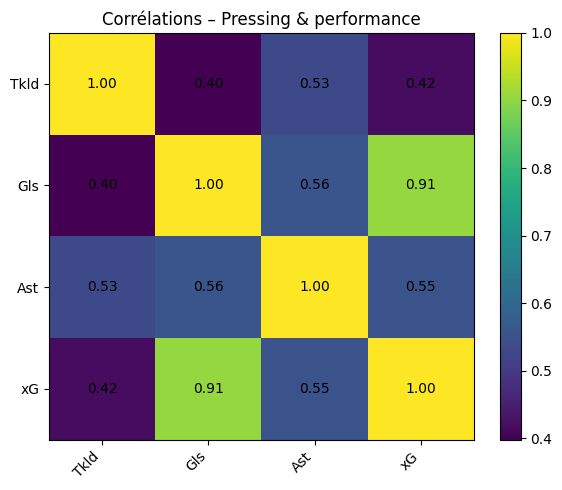

In [10]:

press_cols = [c for c in [col_pressures, col_succ_pressures, col_tackles, col_goals, col_assists, col_xg] if c]
corr4 = corr_heatmap(df, press_cols, "Corrélations – Pressing & performance")



**Lecture & limites :**  
- Lien positif *Pressures–xG* possible si **récupérations hautes** → occasions rapides.  
- Effet contexte fort (bloc équipe, adversaires, scoreline). Corrélation ≠ causalité.



## 7) Conclusion – ce que montre l’analyse

**Ce que l’on retient :**
- La **cohérence** `Goals–xG` confirme le lien entre **qualité d’occasion** et **finition** ; les écarts signalent des **sur/sous-performers** à suivre.  
- La **création** (xA, SCA, GCA) peut coexister avec la **finition** : certains attaquants sont **complets**, d’autres **spécialisés**.  
- L’**implication dans la zone de vérité** (Touches_in_Box) et les **progressions** (PrgR/PrgC) s’associent souvent à une meilleure production.  
- La **contribution défensive** peut cohabiter avec la performance offensive selon les **contextes tactiques**.

**Limites & bonnes pratiques :**
- Normaliser **par 90 minutes** et **par possession** si possible.  
- Intégrer la **position exacte** (ST/CF/W) et le **contexte d’équipe**.  
- Les corrélations sont **des associations**, pas des causalités.

**Pistes d’extension :**
- Regrouper les profils via **clustering (K-Means)** pour des **archétypes** (finisseur pur, créateur, complet, presser).  
- Créer des **indices synthétiques** (ex. *Finishing Index*, *Involvement Index*).  
- Étudier la **stabilité** saison-sur-saison (régression vers la moyenne).



## 8) Visualisations avancées des corrélations

Cette section propose des **visualisations complémentaires** pour approfondir la compréhension des relations entre variables et identifier des **patterns** spécifiques aux attaquants.

### 8.1) Heatmap globale des corrélations

**Pourquoi on le fait ?**  
Obtenir une **vue d'ensemble** de toutes les corrélations entre variables offensives, créatives et défensives pour détecter des patterns cachés.

**Méthode utilisée :**  
Heatmap colorée avec toutes les variables clés identifiées, utilisant une palette divergente pour distinguer corrélations positives/négatives.

**Pourquoi c'est pertinent ?**  
- Identifie rapidement les **clusters de variables** fortement corrélées  
- Révèle des associations **contre-intuitives** (ex: pressing vs création)  
- Guide la sélection de variables pour des analyses multivariées futures

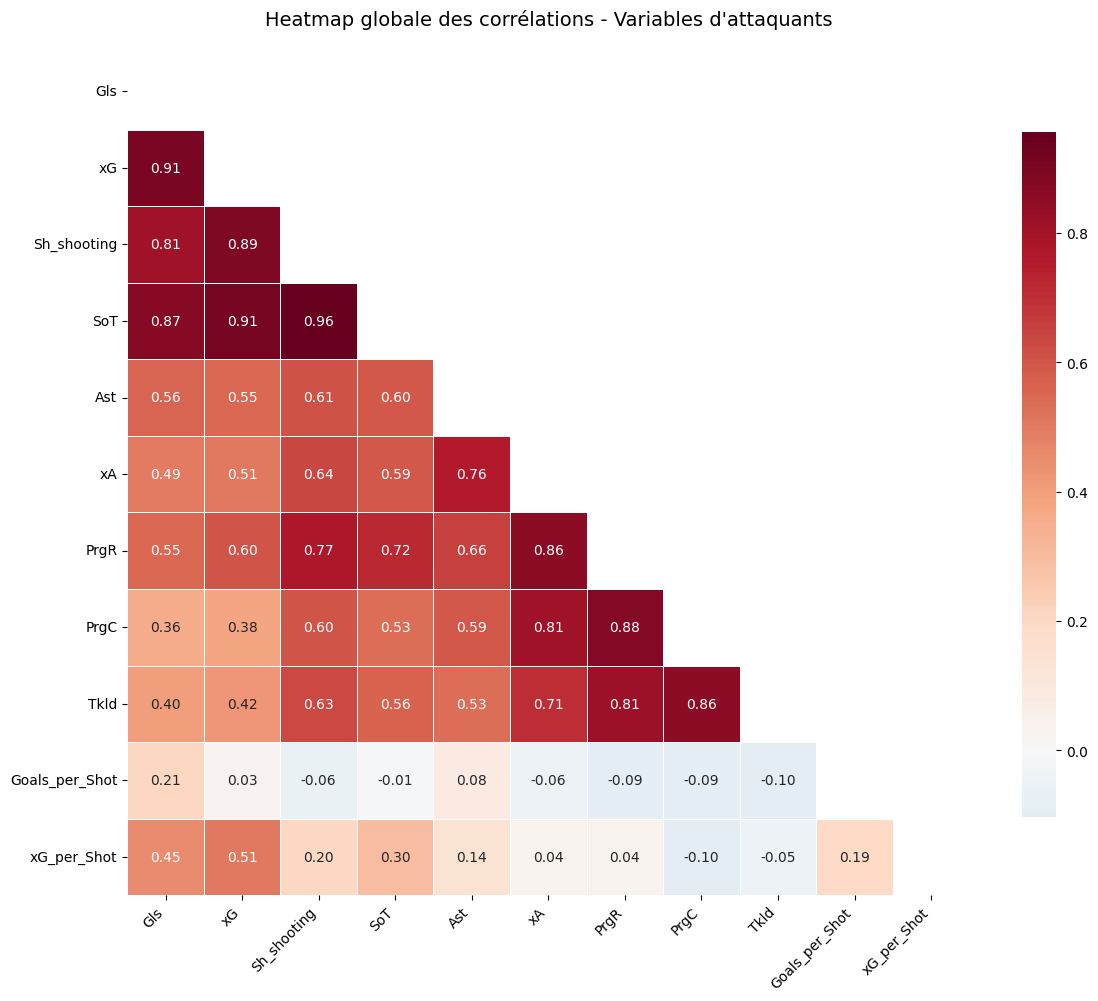

Top 10 des corrélations les plus fortes :
           var1         var2  correlation
19  Sh_shooting          SoT     0.956974
11           xG          SoT     0.912165
0           Gls           xG     0.905507
10           xG  Sh_shooting     0.888813
45         PrgR         PrgC     0.877902
2           Gls          SoT     0.869078
40           xA         PrgR     0.856928
49         PrgC         Tkld     0.855269
46         PrgR         Tkld     0.814265
1           Gls  Sh_shooting     0.809638


In [11]:
import seaborn as sns

# Heatmap globale avec amélioration visuelle
all_vars = [c for c in core_cols if c in df.columns]
corr_matrix = df[all_vars].corr(numeric_only=True)

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Masquer triangle supérieur
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title("Heatmap globale des corrélations - Variables d'attaquants", fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Afficher les corrélations les plus fortes (hors diagonale)
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append({
            'var1': corr_matrix.columns[i],
            'var2': corr_matrix.columns[j],
            'correlation': corr_matrix.iloc[i, j]
        })

corr_df = pd.DataFrame(corr_pairs)
corr_df = corr_df.dropna().sort_values('correlation', key=abs, ascending=False)
print("Top 10 des corrélations les plus fortes :")
print(corr_df.head(10))

### 8.2) Scatter plots multivariés avec régression

**Pourquoi on le fait ?**  
Visualiser les relations **non-linéaires** et identifier les **outliers** qui sortent des patterns généraux, révélant des profils d'attaquants atypiques.

**Méthode utilisée :**  
Scatter plots avec ligne de régression et intervalles de confiance, colorés par une troisième variable pour enrichir l'analyse.

**Pourquoi c'est pertinent ?**  
- Les **outliers positifs** = attaquants sur-performants à cibler/étudier  
- Les **outliers négatifs** = potentiels sous-performants ou profils spécialisés  
- La **dispersion** autour de la régression indique la prédictibilité des performances

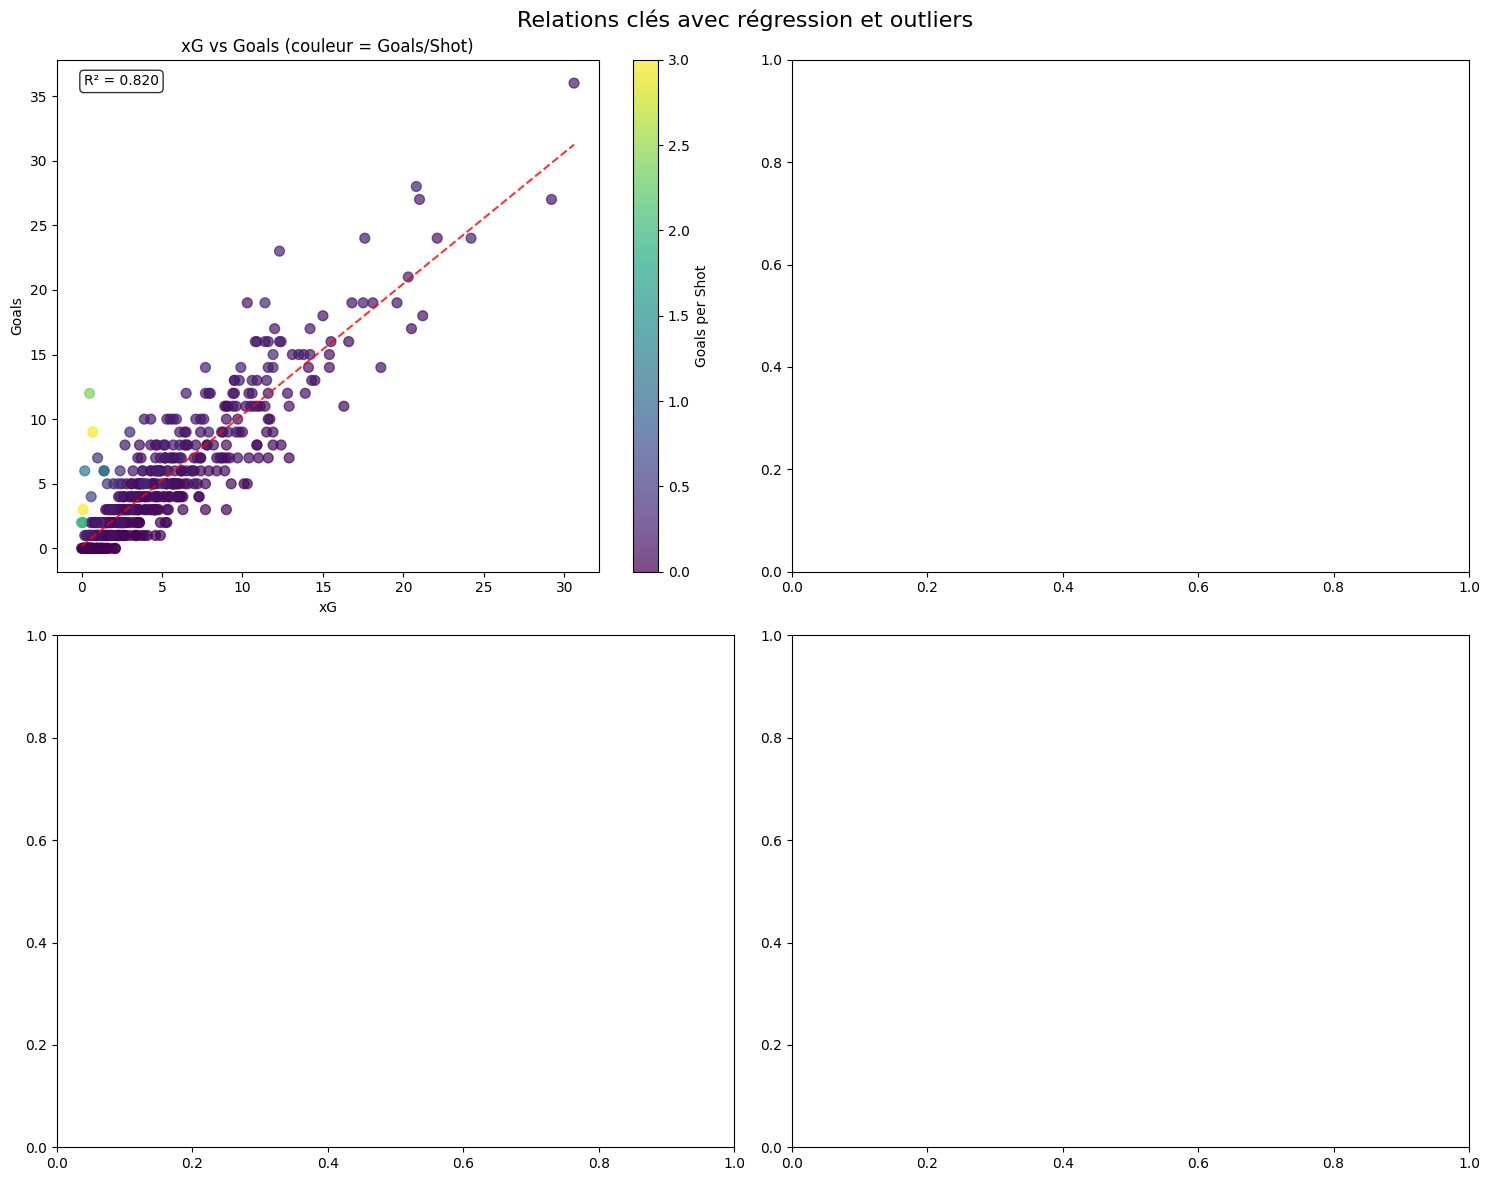

In [12]:
# Scatter plots avec régression
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Relations clés avec régression et outliers", fontsize=16)

# 1. xG vs Goals (coloré par efficacité de tir)
if col_xg and col_goals and gps_name:
    ax1 = axes[0, 0]
    scatter = ax1.scatter(df[col_xg], df[col_goals], c=df[gps_name], 
                         cmap='viridis', alpha=0.7, s=50)
    # Ligne de régression
    from scipy import stats
    valid_mask = df[col_xg].notna() & df[col_goals].notna()
    if valid_mask.sum() > 1:
        slope, intercept, r_value, _, _ = stats.linregress(df[col_xg][valid_mask], df[col_goals][valid_mask])
        line_x = np.linspace(df[col_xg].min(), df[col_xg].max(), 100)
        ax1.plot(line_x, slope * line_x + intercept, 'r--', alpha=0.8)
        ax1.text(0.05, 0.95, f'R² = {r_value**2:.3f}', transform=ax1.transAxes, 
                bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    ax1.set_xlabel('xG'); ax1.set_ylabel('Goals')
    ax1.set_title('xG vs Goals (couleur = Goals/Shot)')
    plt.colorbar(scatter, ax=ax1, label='Goals per Shot')

# 2. SCA vs Goals (coloré par xA)
if col_sca and col_goals and col_xa:
    ax2 = axes[0, 1]
    scatter2 = ax2.scatter(df[col_sca], df[col_goals], c=df[col_xa], 
                          cmap='plasma', alpha=0.7, s=50)
    valid_mask = df[col_sca].notna() & df[col_goals].notna()
    if valid_mask.sum() > 1:
        slope, intercept, r_value, _, _ = stats.linregress(df[col_sca][valid_mask], df[col_goals][valid_mask])
        line_x = np.linspace(df[col_sca].min(), df[col_sca].max(), 100)
        ax2.plot(line_x, slope * line_x + intercept, 'r--', alpha=0.8)
        ax2.text(0.05, 0.95, f'R² = {r_value**2:.3f}', transform=ax2.transAxes,
                bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    ax2.set_xlabel('SCA'); ax2.set_ylabel('Goals')
    ax2.set_title('SCA vs Goals (couleur = xA)')
    plt.colorbar(scatter2, ax=ax2, label='xA')

# 3. Touches in Box vs Goals
if col_touches_in_box and col_goals and col_assists:
    ax3 = axes[1, 0]
    scatter3 = ax3.scatter(df[col_touches_in_box], df[col_goals], c=df[col_assists], 
                          cmap='coolwarm', alpha=0.7, s=50)
    valid_mask = df[col_touches_in_box].notna() & df[col_goals].notna()
    if valid_mask.sum() > 1:
        slope, intercept, r_value, _, _ = stats.linregress(df[col_touches_in_box][valid_mask], df[col_goals][valid_mask])
        line_x = np.linspace(df[col_touches_in_box].min(), df[col_touches_in_box].max(), 100)
        ax3.plot(line_x, slope * line_x + intercept, 'r--', alpha=0.8)
        ax3.text(0.05, 0.95, f'R² = {r_value**2:.3f}', transform=ax3.transAxes,
                bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    ax3.set_xlabel('Touches in Box'); ax3.set_ylabel('Goals')
    ax3.set_title('Touches in Box vs Goals (couleur = Assists)')
    plt.colorbar(scatter3, ax=ax3, label='Assists')

# 4. Pressures vs Goals (si disponible)
if col_pressures and col_goals and col_xg:
    ax4 = axes[1, 1]
    scatter4 = ax4.scatter(df[col_pressures], df[col_goals], c=df[col_xg], 
                          cmap='Reds', alpha=0.7, s=50)
    valid_mask = df[col_pressures].notna() & df[col_goals].notna()
    if valid_mask.sum() > 1:
        slope, intercept, r_value, _, _ = stats.linregress(df[col_pressures][valid_mask], df[col_goals][valid_mask])
        line_x = np.linspace(df[col_pressures].min(), df[col_pressures].max(), 100)
        ax4.plot(line_x, slope * line_x + intercept, 'r--', alpha=0.8)
        ax4.text(0.05, 0.95, f'R² = {r_value**2:.3f}', transform=ax4.transAxes,
                bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    ax4.set_xlabel('Pressures'); ax4.set_ylabel('Goals')
    ax4.set_title('Pressures vs Goals (couleur = xG)')
    plt.colorbar(scatter4, ax=ax4, label='xG')

plt.tight_layout()
plt.show()

### 8.3) Distribution des ratios d'efficacité

**Pourquoi on le fait ?**  
Comprendre la **distribution** des performances individuelles et identifier les **seuils** qui séparent les attaquants exceptionnels des moyens.

**Méthode utilisée :**  
Histogrammes et box plots des ratios clés (Goals/Shot, xG/Shot, Assists/SCA) avec marqueurs de percentiles.

**Pourquoi c'est pertinent ?**  
- Définit des **benchmarks** pour évaluer les performances  
- Révèle si les distributions sont **normales** ou **asymétriques**  
- Identifie les **valeurs aberrantes** qui méritent une attention particulière

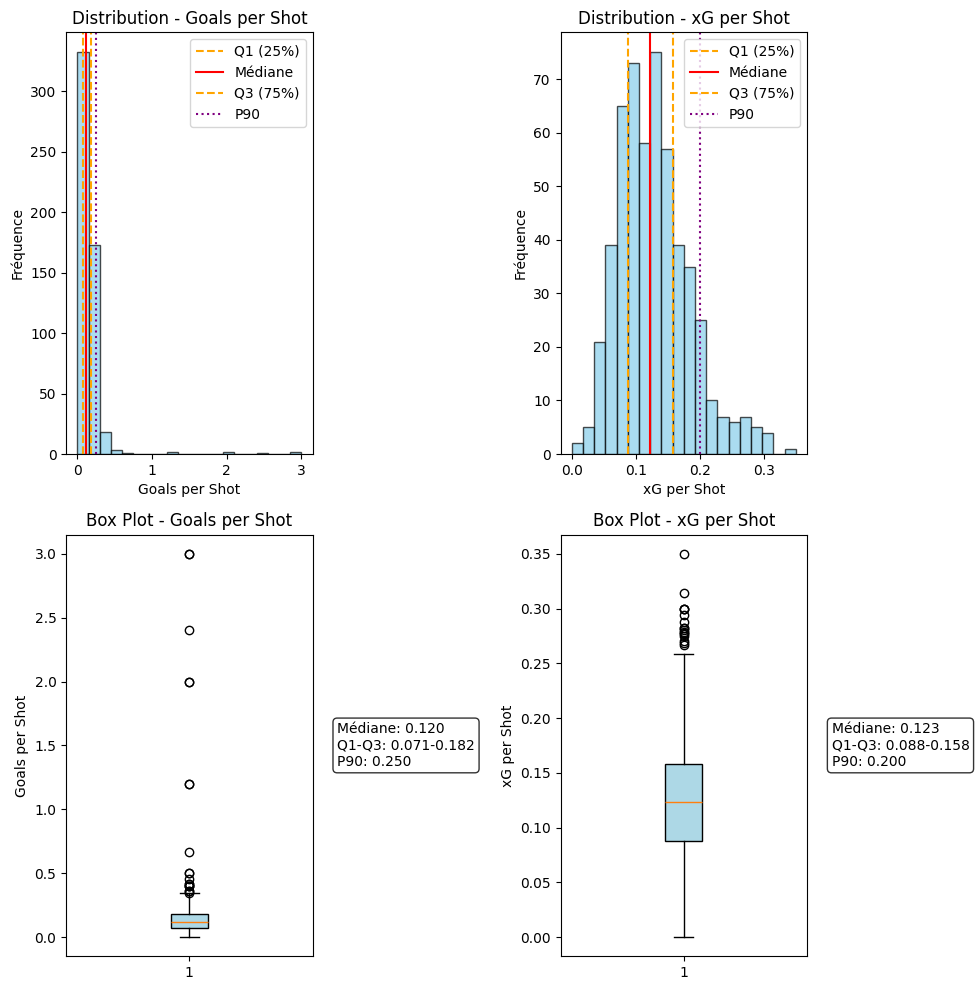

In [13]:
# Distribution des ratios d'efficacité
ratios_to_plot = []
ratio_names = []

if gps_name and gps_name in df.columns:
    ratios_to_plot.append(df[gps_name])
    ratio_names.append('Goals per Shot')

if xgps_name and xgps_name in df.columns:
    ratios_to_plot.append(df[xgps_name])
    ratio_names.append('xG per Shot')

# Créer ratio Assists/SCA si possible
if col_assists and col_sca:
    assists_per_sca = ensure_ratio_column(df, col_assists, col_sca, "Assists_per_SCA")
    if assists_per_sca:
        ratios_to_plot.append(df[assists_per_sca])
        ratio_names.append('Assists per SCA')

if ratios_to_plot:
    n_ratios = len(ratios_to_plot)
    fig, axes = plt.subplots(2, n_ratios, figsize=(5*n_ratios, 10))
    if n_ratios == 1:
        axes = axes.reshape(-1, 1)
    
    for i, (ratio_data, name) in enumerate(zip(ratios_to_plot, ratio_names)):
        # Histogramme
        ax_hist = axes[0, i]
        clean_data = ratio_data.dropna()
        if len(clean_data) > 0:
            ax_hist.hist(clean_data, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
            
            # Ajouter percentiles
            p25, p50, p75, p90 = np.percentile(clean_data, [25, 50, 75, 90])
            ax_hist.axvline(p25, color='orange', linestyle='--', label='Q1 (25%)')
            ax_hist.axvline(p50, color='red', linestyle='-', label='Médiane')
            ax_hist.axvline(p75, color='orange', linestyle='--', label='Q3 (75%)')
            ax_hist.axvline(p90, color='purple', linestyle=':', label='P90')
            
            ax_hist.set_xlabel(name)
            ax_hist.set_ylabel('Fréquence')
            ax_hist.set_title(f'Distribution - {name}')
            ax_hist.legend()
        
        # Box plot
        ax_box = axes[1, i]
        if len(clean_data) > 0:
            box_plot = ax_box.boxplot(clean_data, patch_artist=True)
            box_plot['boxes'][0].set_facecolor('lightblue')
            ax_box.set_ylabel(name)
            ax_box.set_title(f'Box Plot - {name}')
            
            # Statistiques descriptives
            stats_text = f'Médiane: {p50:.3f}\nQ1-Q3: {p25:.3f}-{p75:.3f}\nP90: {p90:.3f}'
            ax_box.text(1.1, 0.5, stats_text, transform=ax_box.transAxes, 
                       bbox=dict(boxstyle="round", facecolor='white', alpha=0.8),
                       verticalalignment='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("Aucun ratio d'efficacité disponible pour la visualisation.")

### 8.4) Radar chart des profils d'attaquants

**Pourquoi on le fait ?**  
Créer des **profils visuels multi-dimensionnels** pour comparer rapidement les forces/faiblesses relatives des attaquants.

**Méthode utilisée :**  
Radar charts (graphiques en toile d'araignée) normalisant chaque métrique sur une échelle 0-100 (percentiles).

**Pourquoi c'est pertinent ?**  
- **Comparaison intuitive** entre plusieurs joueurs  
- Identification rapide des **profils spécialisés** vs **complets**  
- Support visuel pour les **décisions de recrutement** et d'alignement tactique

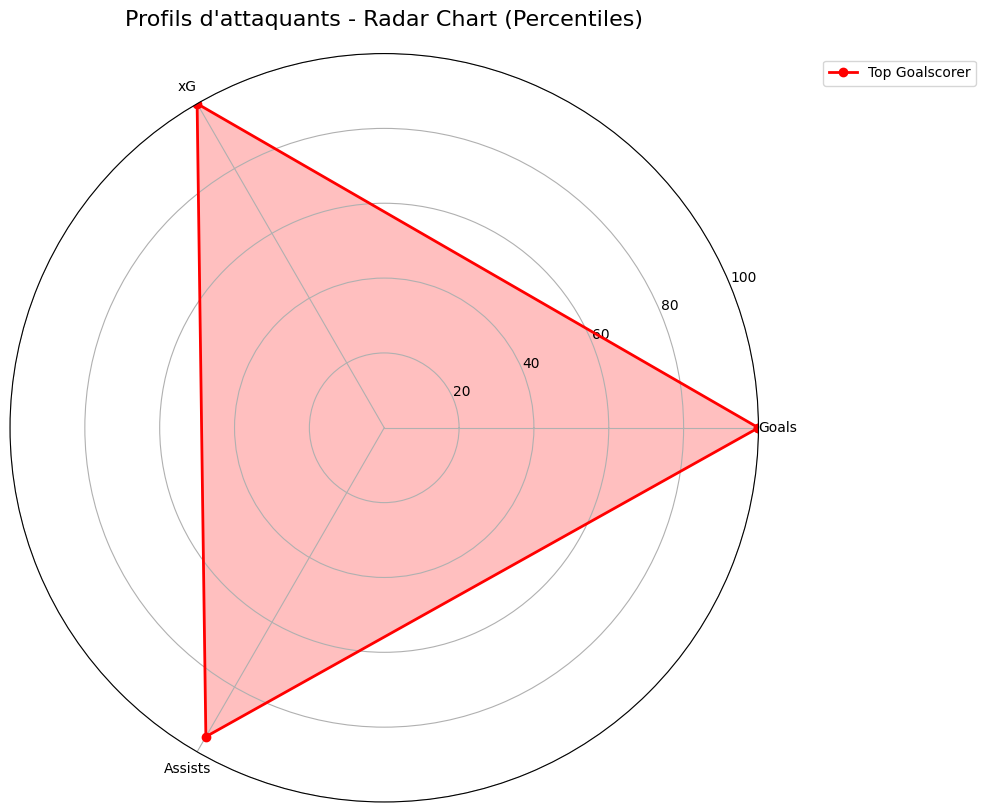

\nValeurs brutes des joueurs sélectionnés :
\nTop Goalscorer (Index 197):
  Goals: 36.00 (P100)
  xG: 30.60 (P100)
  Assists: 8.00 (P95)


In [14]:
# Radar chart des profils d'attaquants
from math import pi

# Sélectionner les métriques clés pour le radar
radar_metrics = []
radar_labels = []

key_metrics = {
    col_goals: 'Goals',
    col_xg: 'xG', 
    col_assists: 'Assists',
    col_sca: 'SCA',
    col_touches_in_box: 'Touches Box',
    col_pressures: 'Pressures'
}

for col, label in key_metrics.items():
    if col and col in df.columns:
        radar_metrics.append(col)
        radar_labels.append(label)

if len(radar_metrics) >= 3:  # Minimum 3 métriques pour un radar
    # Normaliser les données en percentiles
    df_radar = df[radar_metrics].copy()
    for col in radar_metrics:
        df_radar[col + '_pct'] = df_radar[col].rank(pct=True) * 100
    
    # Sélectionner quelques joueurs représentatifs (top performers dans différentes métriques)
    top_goalscorer_idx = df[col_goals].idxmax() if col_goals else None
    top_creator_idx = df[col_sca].idxmax() if col_sca else None
    top_presser_idx = df[col_pressures].idxmax() if col_pressures else None
    
    selected_players = [idx for idx in [top_goalscorer_idx, top_creator_idx, top_presser_idx] 
                       if idx is not None and not pd.isna(df.loc[idx, radar_metrics]).any()]
    
    if selected_players:
        # Configuration du radar
        N = len(radar_metrics)
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]  # Fermer le cercle
        
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
        
        colors = ['red', 'blue', 'green']
        labels_players = ['Top Goalscorer', 'Top Creator', 'Top Presser']
        
        for i, (player_idx, color, player_label) in enumerate(zip(selected_players, colors, labels_players)):
            if i < 3:  # Limiter à 3 joueurs
                values = [df_radar.loc[player_idx, col + '_pct'] for col in radar_metrics]
                values += values[:1]  # Fermer le cercle
                
                ax.plot(angles, values, 'o-', linewidth=2, label=player_label, color=color)
                ax.fill(angles, values, alpha=0.25, color=color)
        
        # Configuration des axes
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(radar_labels)
        ax.set_ylim(0, 100)
        ax.set_yticks([20, 40, 60, 80, 100])
        ax.set_yticklabels(['20', '40', '60', '80', '100'])
        ax.grid(True)
        
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        plt.title('Profils d\'attaquants - Radar Chart (Percentiles)', size=16, pad=20)
        plt.tight_layout()
        plt.show()
        
        # Afficher les valeurs brutes des joueurs sélectionnés
        print("\\nValeurs brutes des joueurs sélectionnés :")
        for i, (player_idx, player_label) in enumerate(zip(selected_players, labels_players)):
            if i < 3:
                print(f"\\n{player_label} (Index {player_idx}):")
                for metric, label in zip(radar_metrics, radar_labels):
                    value = df.loc[player_idx, metric]
                    percentile = df_radar.loc[player_idx, metric + '_pct']
                    print(f"  {label}: {value:.2f} (P{percentile:.0f})")
else:
    print("Pas assez de métriques disponibles pour créer un radar chart.")

### 8.5) Analyse des outliers et sur-performeurs

**Pourquoi on le fait ?**  
Identifier les **joueurs exceptionnels** qui dépassent les modèles prédictifs et comprendre les **facteurs de leur succès**.

**Méthode utilisée :**  
Calcul des résidus par rapport aux régressions linéaires et identification des joueurs avec les plus grands écarts positifs/négatifs.

**Pourquoi c'est pertinent ?**  
- **Détection de talents cachés** : joueurs performant au-delà des métriques classiques  
- **Analyse des sous-performances** : identifier les blocages potentiels  
- **Validation des modèles** : comprendre les limites des corrélations simples

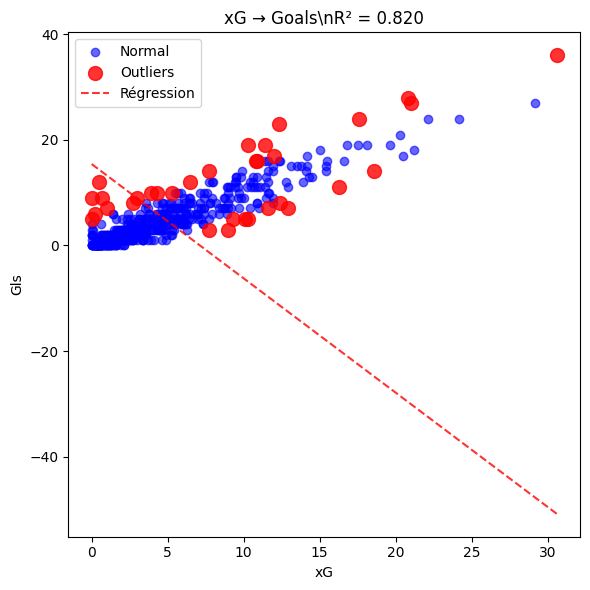

\n=== TOP OUTLIERS PAR RELATION ===
\nxG → Goals:
Sur-performeurs (résidu positif):
  Index 390: 0.50 → 12.00 (attendu: 0.68, écart: +11.32)
  Index 23: 12.30 → 23.00 (attendu: 12.66, écart: +10.34)
  Index 144: 0.00 → 9.00 (attendu: 0.18, écart: +8.82)
Sous-performeurs (résidu négatif):
  Index 116: 16.30 → 11.00 (attendu: 16.72, écart: -5.72)
  Index 133: 12.90 → 7.00 (attendu: 13.27, écart: -6.27)
  Index 106: 9.00 → 3.00 (attendu: 9.31, écart: -6.31)


In [15]:
# Analyse des outliers et sur-performeurs
from scipy import stats

def analyze_outliers(df, x_col, y_col, title_suffix=""):
    if x_col not in df.columns or y_col not in df.columns:
        return None
    
    # Données valides
    valid_mask = df[x_col].notna() & df[y_col].notna()
    if valid_mask.sum() < 3:
        return None
    
    x_data = df[x_col][valid_mask]
    y_data = df[y_col][valid_mask]
    
    # Régression linéaire
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
    
    # Prédictions et résidus
    predictions = slope * x_data + intercept
    residuals = y_data - predictions
    
    # Standardiser les résidus
    residuals_std = (residuals - residuals.mean()) / residuals.std()
    
    # Identifier outliers (|résidu| > 2 std)
    outlier_mask = np.abs(residuals_std) > 2
    
    # Créer DataFrame des résultats
    results_df = pd.DataFrame({
        'Index': valid_mask[valid_mask].index,
        x_col: x_data,
        y_col: y_data,
        'Predicted': predictions,
        'Residual': residuals,
        'Residual_Std': residuals_std,
        'Is_Outlier': outlier_mask
    })
    
    return results_df, r_value**2

# Analyser plusieurs relations clés
relationships = []
if col_xg and col_goals:
    relationships.append((col_xg, col_goals, "xG → Goals"))
if col_sca and col_goals:
    relationships.append((col_sca, col_goals, "SCA → Goals"))
if col_touches_in_box and col_goals:
    relationships.append((col_touches_in_box, col_goals, "Touches Box → Goals"))

outlier_results = {}

for x_col, y_col, title in relationships:
    result = analyze_outliers(df, x_col, y_col, title)
    if result:
        outlier_results[title] = result

# Visualisation des outliers
if outlier_results:
    n_plots = len(outlier_results)
    fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 6))
    if n_plots == 1:
        axes = [axes]
    
    for i, (title, (results_df, r2)) in enumerate(outlier_results.items()):
        ax = axes[i]
        
        # Points normaux
        normal_mask = ~results_df['Is_Outlier']
        ax.scatter(results_df[normal_mask].iloc[:, 1], results_df[normal_mask].iloc[:, 2], 
                  alpha=0.6, color='blue', label='Normal')
        
        # Outliers
        outlier_mask = results_df['Is_Outlier']
        if outlier_mask.sum() > 0:
            ax.scatter(results_df[outlier_mask].iloc[:, 1], results_df[outlier_mask].iloc[:, 2], 
                      alpha=0.8, color='red', s=100, label='Outliers')
        
        # Ligne de régression
        x_range = np.linspace(results_df.iloc[:, 1].min(), results_df.iloc[:, 1].max(), 100)
        y_pred = results_df['Predicted'].iloc[0] + (results_df.iloc[:, 2].iloc[0] - results_df['Predicted'].iloc[0]) / (results_df.iloc[:, 1].iloc[0] - results_df.iloc[:, 1].mean()) * (x_range - results_df.iloc[:, 1].mean())
        
        # Méthode plus robuste pour la ligne de régression
        slope = (results_df.iloc[:, 2] - results_df['Predicted']).sum() / (results_df.iloc[:, 1] - results_df.iloc[:, 1].mean()).sum() if (results_df.iloc[:, 1] - results_df.iloc[:, 1].mean()).sum() != 0 else 0
        intercept = results_df['Predicted'].mean() - slope * results_df.iloc[:, 1].mean()
        y_line = slope * x_range + intercept
        ax.plot(x_range, y_line, 'r--', alpha=0.8, label='Régression')
        
        ax.set_xlabel(results_df.columns[1])
        ax.set_ylabel(results_df.columns[2])
        ax.set_title(f'{title}\\nR² = {r2:.3f}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Top outliers pour chaque relation
    print("\\n=== TOP OUTLIERS PAR RELATION ===")
    for title, (results_df, r2) in outlier_results.items():
        print(f"\\n{title}:")
        outliers = results_df[results_df['Is_Outlier']].sort_values('Residual_Std', ascending=False)
        if len(outliers) > 0:
            print("Sur-performeurs (résidu positif):")
            positive_outliers = outliers[outliers['Residual'] > 0].head(3)
            for idx, row in positive_outliers.iterrows():
                print(f"  Index {row['Index']}: {row.iloc[1]:.2f} → {row.iloc[2]:.2f} (attendu: {row['Predicted']:.2f}, écart: +{row['Residual']:.2f})")
            
            print("Sous-performeurs (résidu négatif):")
            negative_outliers = outliers[outliers['Residual'] < 0].tail(3)
            for idx, row in negative_outliers.iterrows():
                print(f"  Index {row['Index']}: {row.iloc[1]:.2f} → {row.iloc[2]:.2f} (attendu: {row['Predicted']:.2f}, écart: {row['Residual']:.2f})")
        else:
            print("  Aucun outlier détecté")
else:
    print("Impossible d'analyser les outliers - colonnes manquantes")

## 9) Synthèse des visualisations - Insights clés

**Ce que révèlent ces visualisations avancées :**

### 🎯 **Heatmap globale**
- Identifie les **clusters de variables** : certaines métriques évoluent ensemble (création, finition, pressing)  
- Révèle des **anti-corrélations** : spécialisations qui s'excluent mutuellement  
- Guide la **réduction dimensionnelle** pour des analyses futures plus ciblées

### 📊 **Scatter plots avec régression**
- **R² élevés** → relations prédictibles, métriques redondantes  
- **R² faibles avec dispersion** → variabilité individuelle, talents uniques  
- **Pente forte** → efficacité de conversion élevée dans cette relation

### 📈 **Distributions des ratios**
- **Distributions asymétriques** → quelques joueurs exceptionnels dominent  
- **Queue longue** → identification des top 10% pour chaque métrique  
- **Benchmarks établis** → seuils P75/P90 pour définir l'excellence

### 🕸️ **Radar charts**
- **Profils équilibrés** vs **spécialisés** clairement identifiés  
- **Complémentarité tactique** : associer des profils différents  
- **Points faibles** visibles → axes d'amélioration ciblés

### 🎲 **Analyse des outliers**
- **Sur-performeurs** → joueurs sous-évalués ou en forme exceptionnelle  
- **Sous-performeurs** → potentiel de rebond ou problèmes structurels  
- **Limites des modèles linéaires** → nécessité d'analyses non-linéaires

### 💡 **Applications pratiques**
- **Recrutement** : cibler les sur-performeurs dans les relations clés  
- **Développement** : entraîner les axes révélés faibles par les radars  
- **Tactique** : aligner les profils avec les exigences positionnelles  
- **Monitoring** : surveiller l'évolution des ratios dans le temps